# Library

In [1]:
# import torchvision
# torchvision.models.vgg16(pretrained=True).features[:4].eval(),      # 64,H,W 


In [2]:
import os
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
from torchvision.utils import make_grid
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

from model.pgflow import PGFlowV3
from model.landmark_detector.landmark_detector import FacialLandmarkDetector
from model.pgflow.module import InsightFaceModule #get_header
from util import computeGaussian, draw_edge

print(torch.cuda.is_available())


True


In [3]:
tt = T.ToTensor()
ptt = T.PILToTensor()
ttp = T.ToPILImage()

# Model

In [4]:
def load_pgflow():
    ckpt_path = '/home/dajinhan/nas_dajinhan/experiments/pgflow/result/pgflow.ckpt'
    pretrained = {'ckpt_path': ckpt_path}
    net = PGFlowV3(pretrained).eval()
    return net

def load_kd_module():
    ckpt_path = '/home/dajinhan/nas_dajinhan/models/ArcFace/model_ir_se50.pth'
    pretrained = {'ckpt_path': ckpt_path}
    net = InsightFaceModule(pretrained).eval()
    return net

def load_landmark_detector():
    ckpt_path = '/home/dajinhan/nas_dajinhan/models/landmark_detector/checkpoint/mobilefacenet_model_best.pth.tar'
    pretrained = {'ckpt_path': ckpt_path}
    net = FacialLandmarkDetector(pretrained).eval()
    return net


In [5]:
flow = load_pgflow().cuda()
kd_module = load_kd_module().cuda()
landmark_detector = load_landmark_detector().cuda()

/home/dajinhan/nas_dajinhan/workspace/pose-guided-flow/demo/model/common/flow_module/flow.py:119: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  w_s = torch.from_numpy(w_s)


Load flownet - Checkpoint :  /home/dajinhan/nas_dajinhan/experiments/pgflow/result/pgflow.ckpt


# Preprocess

In [6]:
norm_mean = [0.5, 0.5, 0.5]
norm_std = [1.0, 1.0, 1.0]

preprocess = T.Normalize(
    mean=norm_mean, 
    std=norm_std)
reverse_preprocess = T.Normalize(
    mean=[-m/s for m,s in zip(norm_mean, norm_std)],
    std=[1/s for s in norm_std])

In [7]:
def preprocess_batch(im, ldmk):
    # Landmark Conditions
    conditions = []
    res = im.shape[2]
    for _ in range(7):
        # Computer per Image
        heatmap = computeGaussian(ldmk, res=res, kernel_sigma=0.1, device='cuda')
        edgemap = draw_edge(ldmk, img_size=res).cuda()
        condition = torch.cat([heatmap, edgemap], dim=0)
        condition = condition.unsqueeze(0)
        conditions.append(condition)
        res = res // 2

    # Preprocess Inputs
    im = preprocess(im)

    return im, conditions

In [8]:
def sample_grid(x, n_row, padding=2):
    imgs = [img.cpu() for img in x]
    grid = make_grid(imgs, n_row, padding=padding)
    return ttp(grid)

# Sample - Latent Interpolation

In [9]:
im_s = tt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/00002.png')).reshape(1,3,64,64).cuda()
im_t = tt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/00009.png')).reshape(1,3,64,64).cuda()

im_s_resized = T.Resize(112, interpolation=InterpolationMode.BICUBIC, antialias=True)(im_s)
im_t_resized = T.Resize(112, interpolation=InterpolationMode.BICUBIC, antialias=True)(im_t)

ldmk_s, f5p_s = landmark_detector(im_s_resized) # input: (0,1)
ldmk_t, f5p_t = landmark_detector(im_t_resized) # input: (0,1)


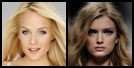

In [10]:
sample_grid(torch.cat([im_s, im_t], dim=0), 2)

In [11]:
with torch.no_grad():
    # Preprocess
    _, conditions_s = preprocess_batch(im_s, ldmk_s[0])
    _, conditions_t = preprocess_batch(im_t, ldmk_t[0])

    # Forward: x->z
    w_s, log_p_s, log_det_s, splits_s, inter_features_s = flow.forward(*preprocess_batch(im_s, ldmk_s[0]))
    w_t, log_p_t, log_det_t, splits_t, inter_features_t = flow.forward(*preprocess_batch(im_t, ldmk_t[0]))

    # setting frames
    frames = []
    n_frames = 10
    w_list = [ (w_t*frame_idx + w_s*(n_frames-frame_idx-1)) / (n_frames-1) for frame_idx in range(n_frames)]
    splits = [torch.zeros_like(split_s) if split_s is not None else split_s for split_s in splits_s]

    # Reverse: z->x
    for w in w_list:    
        # Reverse: z->x
        im_rec = flow.reverse(w, conditions_s, splits)
        im_rec = reverse_preprocess(im_rec)
        im_rec = torch.clamp(im_rec, 0, 1)

        # Update
        frames.append(im_rec)


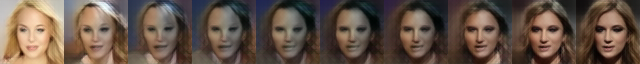

In [12]:
sample_grid(torch.cat(frames, dim=0), n_frames, padding=0)

# Sample - Pose Interpolation

In [13]:
# im_s = tt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/00002.png')).reshape(1,3,64,64).cuda()
# im_t = tt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/00009.png')).reshape(1,3,64,64).cuda()

im_s = tt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kellan_Lutz/1.6/482zKSvHeRw/0003350.png')).reshape(1,3,64,64).cuda()
im_t = tt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kellan_Lutz/1.6/482zKSvHeRw/0003400.png')).reshape(1,3,64,64).cuda()

im_s_resized = T.Resize(112, interpolation=InterpolationMode.BICUBIC, antialias=True)(im_s)
im_t_resized = T.Resize(112, interpolation=InterpolationMode.BICUBIC, antialias=True)(im_t)

ldmk_s, f5p_s = landmark_detector(im_s_resized) # input: (0,1)
ldmk_t, f5p_t = landmark_detector(im_t_resized) # input: (0,1)


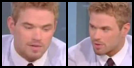

In [14]:
sample_grid(torch.cat([im_s, im_t], dim=0), 2)

In [15]:
with torch.no_grad():
    # Preprocess
    _, conditions_s = preprocess_batch(im_s, ldmk_s[0])
    _, conditions_t = preprocess_batch(im_t, ldmk_t[0])
 
    # Forward: x->z
    w_s, log_p_s, log_det_s, splits_s, inter_features_s = flow.forward(*preprocess_batch(im_s, ldmk_s[0]))
    w_t, log_p_t, log_det_t, splits_t, inter_features_t = flow.forward(*preprocess_batch(im_t, ldmk_t[0]))

    # setting frames
    frames = []
    n_frames = 10
    landmarks = [ (ldmk_t*frame_idx + ldmk_s*(n_frames-frame_idx-1)) / (n_frames-1) for frame_idx in range(n_frames)]
    splits = [torch.zeros_like(split_s) if split_s is not None else split_s for split_s in splits_s]

    # Reverse: z->x
    for idx, landmark in enumerate(landmarks):
        _, conditions = preprocess_batch(im_s, landmark[0])

        # Reverse: z->x
        im_rec = flow.reverse(w_s, conditions, splits)
        im_rec = reverse_preprocess(im_rec)
        im_rec = torch.clamp(im_rec, 0, 1)

        # Update
        frames.append(im_rec)


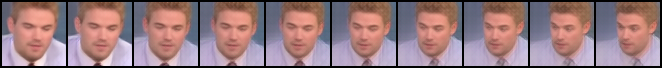

In [16]:
sample_grid(torch.cat(frames, dim=0), n_frames+1)

# Sample - Figure_1

In [17]:
def sample_figure(im_s, im_t):
    with torch.no_grad():
        # Get LDMK
        im_s_resized = T.Resize(112, interpolation=InterpolationMode.BICUBIC, antialias=True)(im_s)
        im_t_resized = T.Resize(112, interpolation=InterpolationMode.BICUBIC, antialias=True)(im_t)
        ldmk_s, f5p_s = landmark_detector(im_s_resized) # input: (0,1)
        ldmk_t, f5p_t = landmark_detector(im_t_resized) # input: (0,1)

        # Preprocess
        im_s, conditions_s = preprocess_batch(im_s, ldmk_s[0])
        im_t, conditions_t = preprocess_batch(im_t, ldmk_t[0])

        # Forward: x->z
        w, log_p, log_det, splits, inter_features = flow.forward(im_s, conditions_s)
        splits = [torch.zeros_like(split) if split is not None else split for split in splits]

        # Reverse: z->x
        im_rec = flow.reverse(w, conditions_t, splits)
        im_rec = reverse_preprocess(im_rec)
        im_rec = torch.clamp(im_rec, 0, 1)
    
    return im_rec

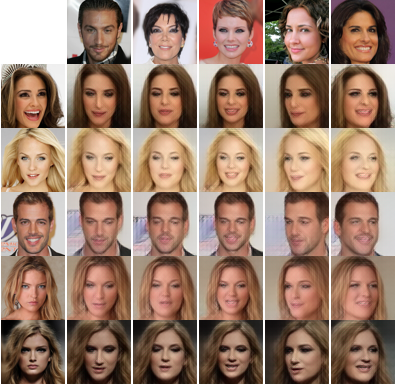

In [18]:
gens = []
gens.append(torch.ones((1,3,64,64)).cuda())
for t_idx in [31,32,34,3,4]:
    im_t = tt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/%.5d.png'%(t_idx))).reshape(1,3,64,64).cuda()
    gens.append(im_t)
for s_idx in  [1,2,40,6,9]:
    im_s = tt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/%.5d.png'%(s_idx))).reshape(1,3,64,64).cuda()
    gens.append(im_s)
    for t_idx in [31,32,34,3,4]:
        im_t = tt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/%.5d.png'%(t_idx))).reshape(1,3,64,64).cuda()
        gens.append(sample_figure(im_s, im_t))
        
gens2 = [F.pad(gg, (1,1), mode='constant', value=1) for gg in gens]
sample_grid(torch.cat(gens2, dim=0), 6, padding=0)

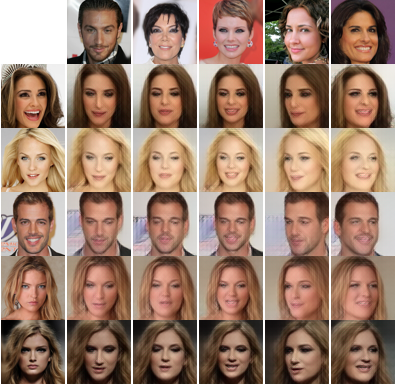

In [19]:
gens = []
gens.append(torch.ones((1,3,64,64)).cuda())
for t_idx in [31,32,34,3,4]:
    im_t = tt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/%.5d.png'%(t_idx))).reshape(1,3,64,64).cuda()
    gens.append(im_t)
for s_idx in  [1,2,40,6,9]:
    im_s = tt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/%.5d.png'%(s_idx))).reshape(1,3,64,64).cuda()
    gens.append(im_s)
    for t_idx in [31,32,34,3,4]:
        im_t = tt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/%.5d.png'%(t_idx))).reshape(1,3,64,64).cuda()
        gens.append(sample_figure(im_s, im_t))
        
gens2 = [F.pad(gg, (1,1), mode='constant', value=1) for gg in gens]
sample_grid(torch.cat(gens2, dim=0), 6, padding=0)

# Sample - Figure_2

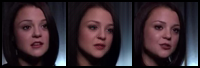

In [22]:
im_s2 = tt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kathryn_Prescott/1.6/8QNLnekKaPU/0000400.png')).reshape(1,3,64,64).cuda()
im_t2 = tt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kathryn_Prescott/1.6/8QNLnekKaPU/0010400.png')).reshape(1,3,64,64).cuda()

im_rec2 = sample_figure(im_s2, im_t2)
sample_grid(torch.cat([im_s2, im_rec2, im_t2], dim=0), 3)

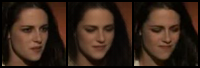

In [23]:
im_s2 = tt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kristen_Stewart/1.6/nU6gCC3DTCc/0002150.png')).reshape(1,3,64,64).cuda()
im_t2 = tt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kristen_Stewart/1.6/nU6gCC3DTCc/0001925.png')).reshape(1,3,64,64).cuda()

im_rec2 = sample_figure(im_s2, im_t2)
sample_grid(torch.cat([im_s2, im_rec2, im_t2], dim=0), 3)